In [1]:
import h5py
import numpy as np
import pandas as pd
import scipy
from scipy import signal
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

2023-04-02 12:57:36.469941: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def getData(cfileName):

    # Read the *.cfile which has each element in float32 format.
    data = np.fromfile(cfileName, dtype="float32")

    # Take each consecutive interleaved I sample and Q sample to create a single complex element.
    data = data[0::2] + 1j*data[1::2]
    #print("data type=", type(data))
    # Return the complex numpy array.
    return data

def create_dataset(data, class_label):
    f, t, Zxx = signal.stft(data, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)
    print(len(f))
    print(len(t))
    print(Zxx.shape)

    del data

    Zxx = Zxx.transpose()

    Zxx = abs(Zxx)
    # scaling the features (only real part of the data can be used)
    scaler = MinMaxScaler()
    scaler.fit(Zxx)
    print(scaler.data_max_)
    Zxx = scaler.transform(Zxx)

    X = Zxx[:num_samp_per_class]
    Y = np.full(num_samp_per_class, class_label)

    return X, Y

# number of samples per class
num_samp_per_class = 10000

# FFT size for the STFT operation (which is same as the feature vector size)
fft_size = feature_vector_size = 2048 #1024

# number of overlapping samples for the STFT operation
fft_overlap = 256

## Nordic Device-25 Own Models

## Nordic Device-25(i) dataset @2.4GHz

In [3]:
class_label = 8
for i in range(class_label):

    folder_path = "/Volumes/Transcend/PhD in Computing/Data Collection/Nordic/2.4GHz/Device-25(i)/"

    if(i==0):
        data = getData(folder_path + "BLINK_new.cfile")
        print(np.array(data))
        X, Y = create_dataset(data, i)

    else:

        if(i==1):
            data = getData(folder_path + "blinky_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==2):
            data = getData(folder_path + "blinky_rtc_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==3):
            data = getData(folder_path + "blinky_systick.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==4):
            data = getData(folder_path + "blinky.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==5):
            data = getData(folder_path + "IDLE_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==6):
            data = getData(folder_path + "led_softblink.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==7):
            data = getData(folder_path + "Matrix_MUL_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        X = np.concatenate((X, dataset), axis=0) 
        Y = np.concatenate((Y, label), axis=0)
        
    print(i)
    print(X.shape)
    print(Y.shape)

# combine all em signals into one dataframe
em_data = pd.DataFrame(X)
em_data.insert(len(em_data.columns), 'labels', Y)

# save to csv file
#(em_data.T).to_csv(f'/Users/Lojenaa/Documents/DELL_Linux/Lojenaa/HackRF One/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone6S/i6S_I.csv', header=False)
# (em_data.T).to_csv(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone8/i8_I.csv', header=False)

[ 0.1484375-0.1015625j -0.1484375+0.015625j   0.1328125+0.078125j  ...
  0.015625 +0.0234375j -0.0078125+0.j         0.015625 -0.015625j ]
2048
76292
(2048, 76292)
[0.02304151 0.01372733 0.00767203 ... 0.00604211 0.00902683 0.0158059 ]
0
(10000, 2048)
(10000,)
[0.015625 +0.0390625j 0.0078125+0.0234375j 0.0234375+0.03125j   ...
 0.0078125+0.015625j  0.015625 -0.015625j  0.0390625+0.015625j ]
2048
74829
(2048, 74829)
[0.03645707 0.02272444 0.02288751 ... 0.01626165 0.01483684 0.02015023]
1
(20000, 2048)
(20000,)
[ 0.015625 -0.0078125j  0.015625 +0.j         0.0390625+0.j        ...
  0.0546875-0.0546875j -0.0078125-0.0234375j -0.0078125+0.046875j ]
2048
93188
(2048, 93188)
[0.02492413 0.01620811 0.01193636 ... 0.00767729 0.00874157 0.01618275]
2
(30000, 2048)
(30000,)
[0.0234375+0.046875j  0.0078125-0.015625j  0.015625 +0.0390625j ...
 0.0234375-0.0078125j 0.0078125+0.03125j   0.0234375-0.0078125j]
2048
87043
(2048, 87043)
[0.03568901 0.04547737 0.04691659 ... 0.01617019 0.02237181 0.022

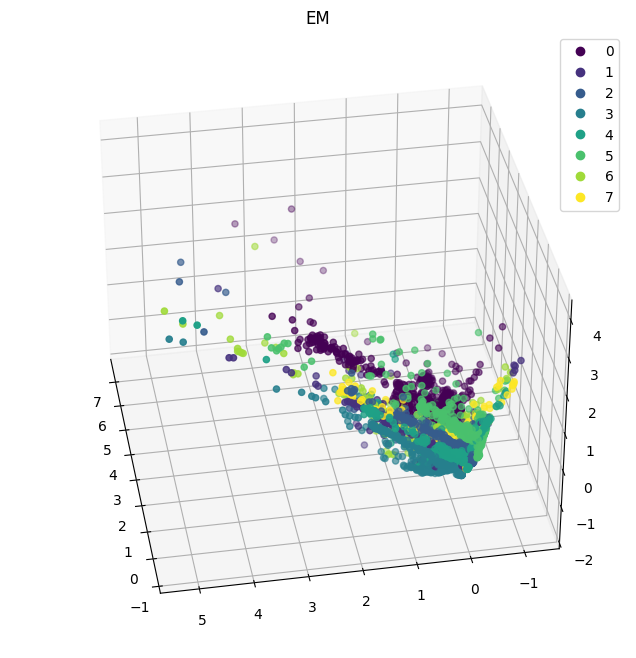

In [4]:
from sklearn.decomposition import PCA

def plot_3d(signal, plot_name, colors, labels, out_path):
    pca = PCA(n_components=3)
    pca_data =pd.DataFrame(pca.fit_transform(signal))
    # visualize in 3d
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    scatter =ax.scatter(pca_data[0],pca_data[1],pca_data[2], c=colors)
    ax.view_init(elev=35, azim=170)
    ax.legend(handles=scatter.legend_elements()[0], loc="best", labels=labels);
    ax.set_title(plot_name);
    plt.savefig(out_path)

# EM scatter
data = em_data
labels = data['labels']
data = data.drop(columns=['labels'])
data = data.dropna(axis='columns')
unique_labels = labels.unique()
labels2colors = {}
classes = []
for i,unique_label in enumerate(unique_labels):
    labels2colors[unique_label] = i
    classes.append(unique_label)
colors = [labels2colors[label] for label in labels]
plot_3d(data,"EM", colors, classes,f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(i)_scatter.pdf')

In [5]:
# Split data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

In [6]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(feature_vector_size,)))
model.add(keras.layers.Dense(1400, activation="relu"))
model.add(keras.layers.Dense(800, activation="relu"))
model.add(keras.layers.Dense(500, activation="relu"))
model.add(keras.layers.Dense(200, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(8, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

2023-04-02 13:21:13.478790: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

checkpoint_cb = keras.callbacks.ModelCheckpoint("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(i)_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=30, validation_split=0.1, callbacks=[checkpoint_cb])

Epoch 1/30
2025/2025 [==============================] - 26s 12ms/step - loss: 2.0460 - accuracy: 0.4606 - val_loss: 2.0054 - val_accuracy: 0.6219
Epoch 2/30
2025/2025 [==============================] - 21s 10ms/step - loss: 1.9249 - accuracy: 0.5823 - val_loss: 1.8106 - val_accuracy: 0.6415
Epoch 3/30
2025/2025 [==============================] - 22s 11ms/step - loss: 1.7169 - accuracy: 0.7025 - val_loss: 1.6199 - val_accuracy: 0.8165
Epoch 4/30
2025/2025 [==============================] - 22s 11ms/step - loss: 1.4976 - accuracy: 0.8113 - val_loss: 1.3341 - val_accuracy: 0.7714
Epoch 5/30
2025/2025 [==============================] - 22s 11ms/step - loss: 1.1276 - accuracy: 0.8953 - val_loss: 0.9174 - val_accuracy: 0.9638
Epoch 6/30
2025/2025 [==============================] - 23s 11ms/step - loss: 0.7195 - accuracy: 0.9764 - val_loss: 0.5552 - val_accuracy: 0.9783
Epoch 7/30
2025/2025 [==============================] - 22s 11ms/step - loss: 0.4260 - accuracy: 0.9812 - val_loss: 0.3381 -

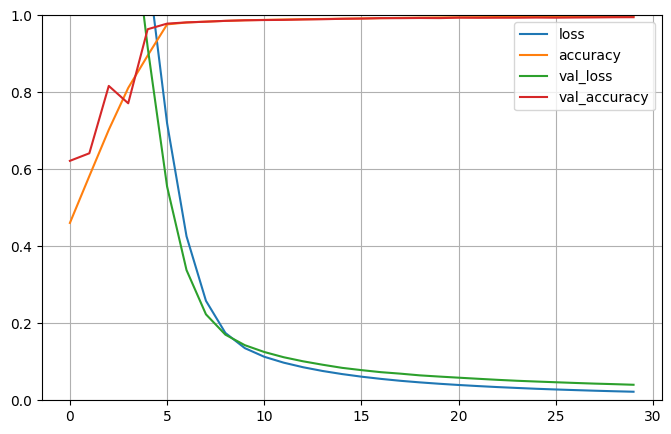

In [8]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone14Pro/accuracy_and_loss_iPhone14Pro_I.pdf')

In [9]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(i)_model.h5")

In [10]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

250/250 [==============================] - 2s 4ms/step - loss: 0.0258 - accuracy: 0.9960
test loss, test acc: [0.02582656219601631, 0.9959999918937683]


In [11]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

250/250 [==============================] - 1s 4ms/step
[0 0 3 ... 6 4 6]
0
[[ 926    0    0    0    0    0    0    1]
 [   0  992    0    0    3    2    1    1]
 [   0    0  974    0    3    2    0    0]
 [   0    0    0  975    0    0    1    0]
 [   0    1    0    0 1077    2    0    0]
 [   0    0    2    0    2 1011    0    1]
 [   1    4    0    1    0    0 1009    0]
 [   0    0    1    0    0    2    1 1004]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       927
           1       0.99      0.99      0.99       999
           2       1.00      0.99      1.00       979
           3       1.00      1.00      1.00       976
           4       0.99      1.00      0.99      1080
           5       0.99      1.00      0.99      1016
           6       1.00      0.99      1.00      1015
           7       1.00      1.00      1.00      1008

    accuracy                           1.00      8000
   macro avg       1.00      1.00     

Test Accuracy:0.996


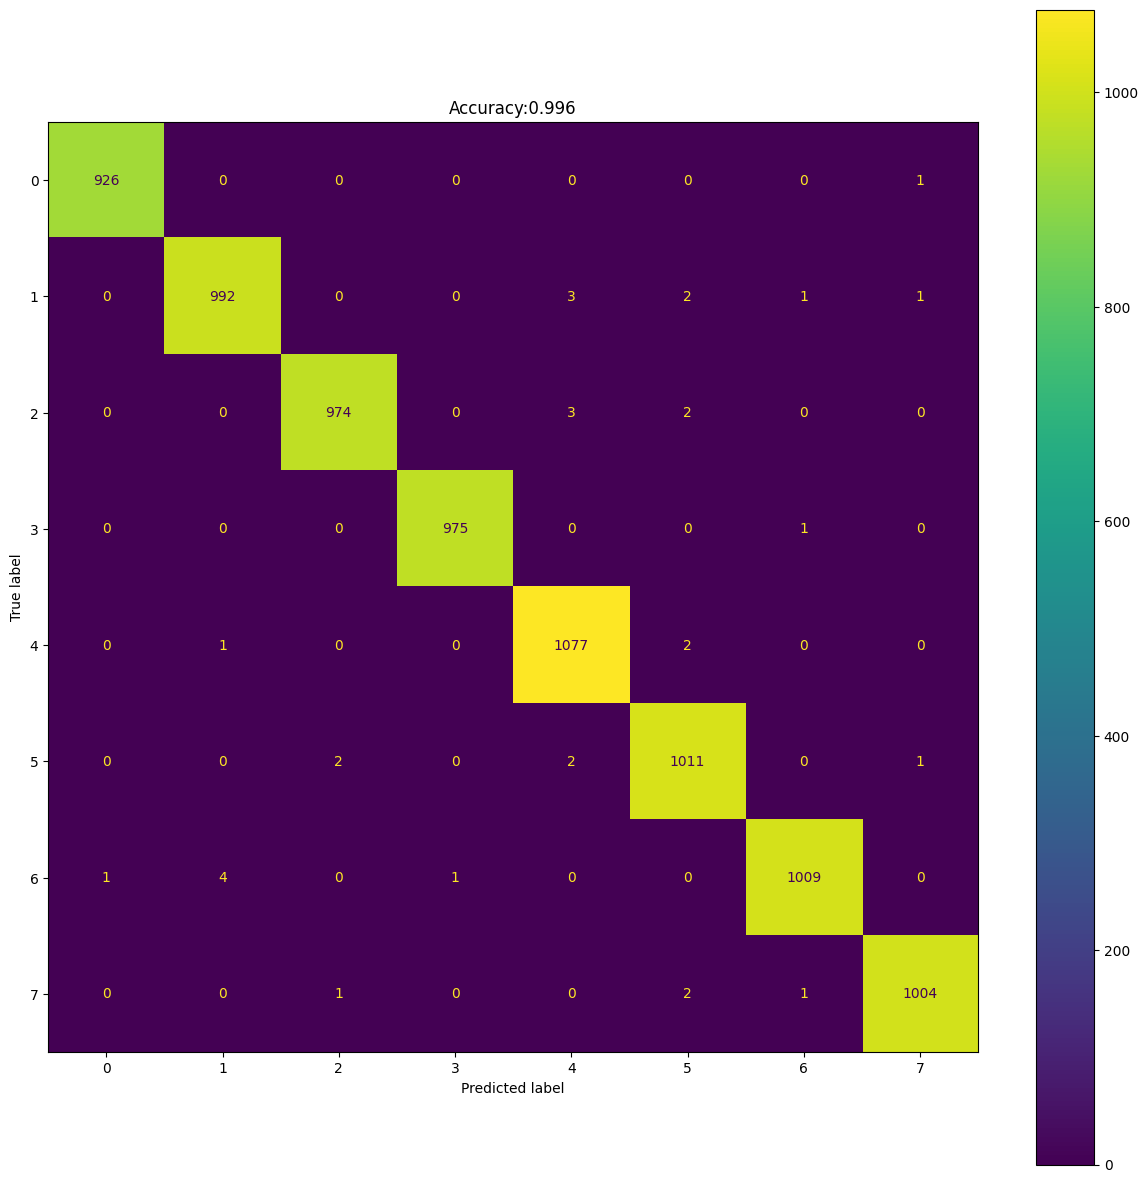

In [12]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,y_test)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/iNordic-25(i)_confusion_matrix.pdf')

## Nordic Device-25(ii) dataset @2.4GHz

In [13]:
class_label = 8
for i in range(class_label):

    folder_path = "/Volumes/Transcend/PhD in Computing/Data Collection/Nordic/2.4GHz/Device-25(ii)/"

    if(i==0):
        data = getData(folder_path + "BLINK_new.cfile")
        print(np.array(data))
        X, Y = create_dataset(data, i)

    else:

        if(i==1):
            data = getData(folder_path + "blinky_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==2):
            data = getData(folder_path + "blinky_rtc_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==3):
            data = getData(folder_path + "blinky_systick.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==4):
            data = getData(folder_path + "blinky.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==5):
            data = getData(folder_path + "IDLE_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==6):
            data = getData(folder_path + "led_softblink.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==7):
            data = getData(folder_path + "Matrix_MUL_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        X = np.concatenate((X, dataset), axis=0) 
        Y = np.concatenate((Y, label), axis=0)
        
    print(i)
    print(X.shape)
    print(Y.shape)

# combine all em signals into one dataframe
em_data = pd.DataFrame(X)
em_data.insert(len(em_data.columns), 'labels', Y)

# save to csv file
#(em_data.T).to_csv(f'/Users/Lojenaa/Documents/DELL_Linux/Lojenaa/HackRF One/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone6S/i6S_I.csv', header=False)
# (em_data.T).to_csv(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone8/i8_I.csv', header=False)

[0.03125  +0.0234375j 0.0078125+0.015625j  0.015625 -0.015625j  ...
 0.0078125+0.015625j  0.015625 +0.0234375j 0.0234375+0.015625j ]
2048
83531
(2048, 83531)
[0.02263969 0.01529919 0.00737484 ... 0.00566509 0.00591057 0.0144904 ]
0
(10000, 2048)
(10000,)
[0.015625 +0.j        0.0234375+0.j        0.0078125+0.0078125j ...
 0.03125  -0.0078125j 0.0234375+0.0234375j 0.015625 +0.j       ]
2048
78338
(2048, 78338)
[0.02961238 0.02458162 0.01655033 ... 0.01719333 0.01524334 0.02118837]
1
(20000, 2048)
(20000,)
[ 0.015625 +0.0078125j  0.03125  +0.0078125j  0.0078125-0.0078125j ...
  0.0234375+0.015625j  -0.015625 +0.j         0.015625 +0.j       ]
2048
89602
(2048, 89602)
[0.02333087 0.01611337 0.00931103 ... 0.01022751 0.01212663 0.01650324]
2
(30000, 2048)
(30000,)
[ 0.015625 -0.015625j   0.0078125+0.0078125j  0.0078125+0.0234375j ...
  0.0234375+0.0078125j -0.0078125+0.0078125j  0.0234375+0.0390625j]
2048
81231
(2048, 81231)
[0.03361239 0.02737371 0.02076487 ... 0.02096687 0.02091695 0.028

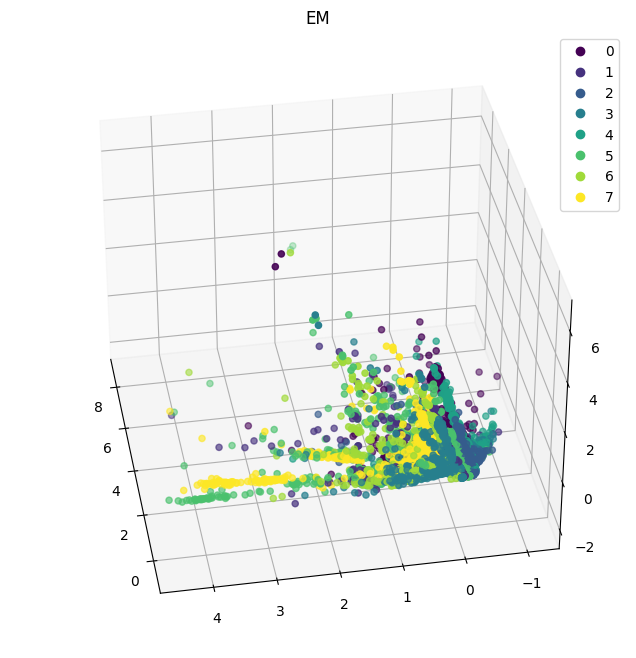

In [14]:
from sklearn.decomposition import PCA

def plot_3d(signal, plot_name, colors, labels, out_path):
    pca = PCA(n_components=3)
    pca_data =pd.DataFrame(pca.fit_transform(signal))
    # visualize in 3d
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    scatter =ax.scatter(pca_data[0],pca_data[1],pca_data[2], c=colors)
    ax.view_init(elev=35, azim=170)
    ax.legend(handles=scatter.legend_elements()[0], loc="best", labels=labels);
    ax.set_title(plot_name);
    plt.savefig(out_path)

# EM scatter
data = em_data
labels = data['labels']
data = data.drop(columns=['labels'])
data = data.dropna(axis='columns')
unique_labels = labels.unique()
labels2colors = {}
classes = []
for i,unique_label in enumerate(unique_labels):
    labels2colors[unique_label] = i
    classes.append(unique_label)
colors = [labels2colors[label] for label in labels]
plot_3d(data,"EM", colors, classes,f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(ii)_scatter.pdf')

In [15]:
# Split data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

In [16]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(feature_vector_size,)))
model.add(keras.layers.Dense(1400, activation="relu"))
model.add(keras.layers.Dense(800, activation="relu"))
model.add(keras.layers.Dense(500, activation="relu"))
model.add(keras.layers.Dense(200, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(8, activation="softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [17]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

checkpoint_cb = keras.callbacks.ModelCheckpoint("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(ii)_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=30, validation_split=0.1, callbacks=[checkpoint_cb])

Epoch 1/30
2025/2025 [==============================] - 24s 12ms/step - loss: 2.0633 - accuracy: 0.4525 - val_loss: 2.0456 - val_accuracy: 0.6257
Epoch 2/30
2025/2025 [==============================] - 23s 11ms/step - loss: 2.0200 - accuracy: 0.8121 - val_loss: 1.9863 - val_accuracy: 0.9047
Epoch 3/30
2025/2025 [==============================] - 21s 10ms/step - loss: 1.9260 - accuracy: 0.8927 - val_loss: 1.8351 - val_accuracy: 0.8531
Epoch 4/30
2025/2025 [==============================] - 25s 12ms/step - loss: 1.6655 - accuracy: 0.7729 - val_loss: 1.4401 - val_accuracy: 0.7272
Epoch 5/30
2025/2025 [==============================] - 25s 12ms/step - loss: 1.1887 - accuracy: 0.8139 - val_loss: 0.9089 - val_accuracy: 0.8344
Epoch 6/30
2025/2025 [==============================] - 26s 13ms/step - loss: 0.7154 - accuracy: 0.8992 - val_loss: 0.5319 - val_accuracy: 0.9343
Epoch 7/30
2025/2025 [==============================] - 23s 11ms/step - loss: 0.4406 - accuracy: 0.9658 - val_loss: 0.3287 -

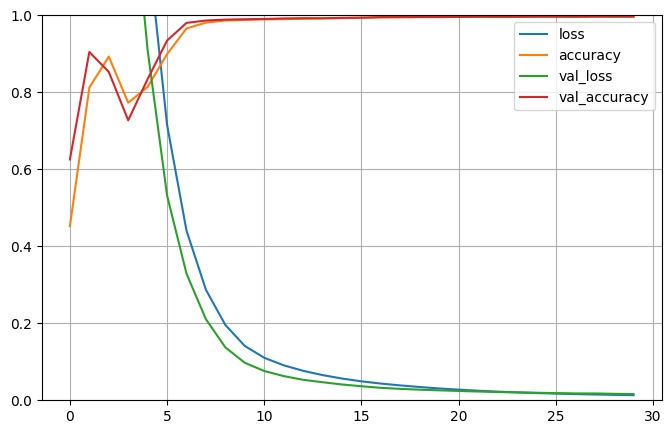

In [18]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [19]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(ii)_model.h5")

In [20]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

250/250 [==============================] - 1s 4ms/step - loss: 0.0178 - accuracy: 0.9967
test loss, test acc: [0.017786379903554916, 0.996749997138977]


In [21]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

250/250 [==============================] - 1s 5ms/step
[0 0 3 ... 6 4 6]
0
[[ 924    0    0    0    3    0    0    0]
 [   2  995    0    0    2    0    0    0]
 [   0    0  979    0    0    0    0    0]
 [   0    0    0  974    0    0    2    0]
 [   3    2    6    0 1068    1    0    0]
 [   0    0    0    0    0 1015    1    0]
 [   0    0    0    0    0    1 1014    0]
 [   0    0    0    3    0    0    0 1005]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       927
           1       1.00      1.00      1.00       999
           2       0.99      1.00      1.00       979
           3       1.00      1.00      1.00       976
           4       1.00      0.99      0.99      1080
           5       1.00      1.00      1.00      1016
           6       1.00      1.00      1.00      1015
           7       1.00      1.00      1.00      1008

    accuracy                           1.00      8000
   macro avg       1.00      1.00     

Test Accuracy:0.99675


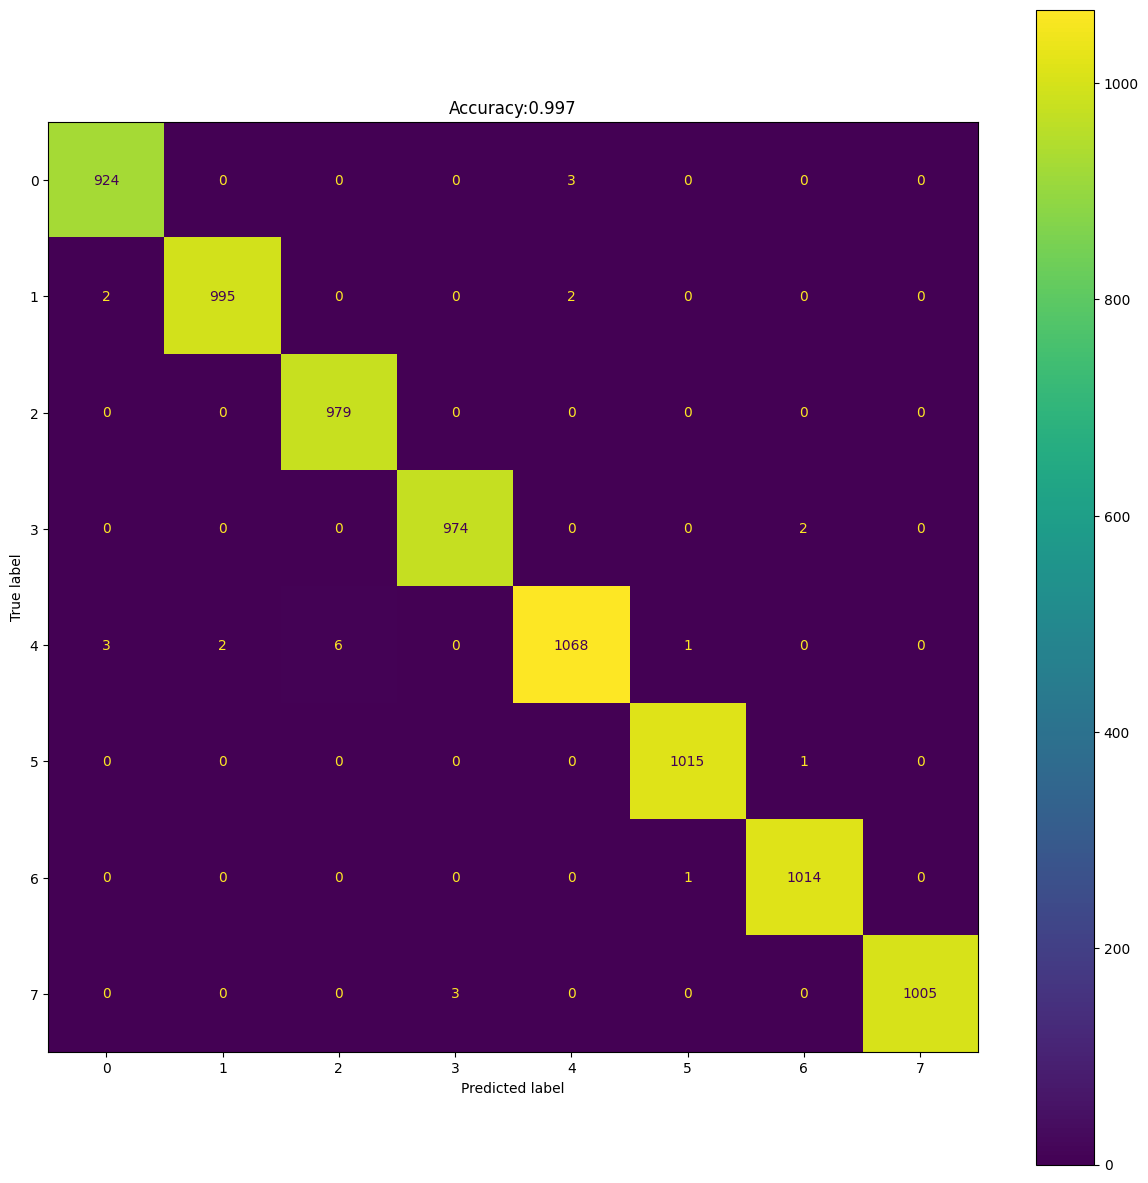

In [22]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,y_test)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/iNordic-25(ii)_confusion_matrix.pdf')

## Nordic Device-25(iii) dataset @2.4GHz

In [23]:
class_label = 8
for i in range(class_label):

    folder_path = "/Volumes/Transcend/PhD in Computing/Data Collection/Nordic/2.4GHz/Device-25(iii)/"

    if(i==0):
        data = getData(folder_path + "BLINK_new.cfile")
        print(np.array(data))
        X, Y = create_dataset(data, i)

    else:

        if(i==1):
            data = getData(folder_path + "blinky_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==2):
            data = getData(folder_path + "blinky_rtc_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==3):
            data = getData(folder_path + "blinky_systick.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==4):
            data = getData(folder_path + "blinky.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==5):
            data = getData(folder_path + "IDLE_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==6):
            data = getData(folder_path + "led_softblink.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==7):
            data = getData(folder_path + "Matrix_MUL_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        X = np.concatenate((X, dataset), axis=0) 
        Y = np.concatenate((Y, label), axis=0)
        
    print(i)
    print(X.shape)
    print(Y.shape)

# combine all em signals into one dataframe
em_data = pd.DataFrame(X)
em_data.insert(len(em_data.columns), 'labels', Y)

# save to csv file
#(em_data.T).to_csv(f'/Users/Lojenaa/Documents/DELL_Linux/Lojenaa/HackRF One/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone6S/i6S_I.csv', header=False)
# (em_data.T).to_csv(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone8/i8_I.csv', header=False)

[0.015625 +0.015625j  0.03125  -0.015625j  0.0078125+0.0078125j ...
 0.03125  +0.0078125j 0.03125  +0.015625j  0.       -0.03125j  ]
2048
83681
(2048, 83681)
[0.02104321 0.01540871 0.00928071 ... 0.00566445 0.00925158 0.01326612]
0
(10000, 2048)
(10000,)
[ 0.03125  +0.015625j   0.015625 +0.j         0.015625 +0.03125j   ...
  0.0234375-0.0078125j  0.015625 +0.015625j  -0.0078125+0.0234375j]
2048
88285
(2048, 88285)
[0.02849545 0.02305507 0.02355783 ... 0.02137687 0.02124649 0.02164258]
1
(20000, 2048)
(20000,)
[-0.0078125+0.0078125j -0.03125  +0.0078125j  0.0546875+0.015625j  ...
  0.0234375+0.j         0.0234375-0.0234375j  0.       -0.0078125j]
2048
79801
(2048, 79801)
[0.02398571 0.01750634 0.00994911 ... 0.00940471 0.00810553 0.01739133]
2
(30000, 2048)
(30000,)
[ 0.03125  +0.015625j   0.0234375-0.0078125j  0.03125  -0.015625j  ...
 -0.1328125-0.3359375j  0.28125  -0.2265625j  0.2890625+0.25j     ]
2048
86311
(2048, 86311)
[0.04492214 0.05376678 0.05611761 ... 0.03631224 0.03270427

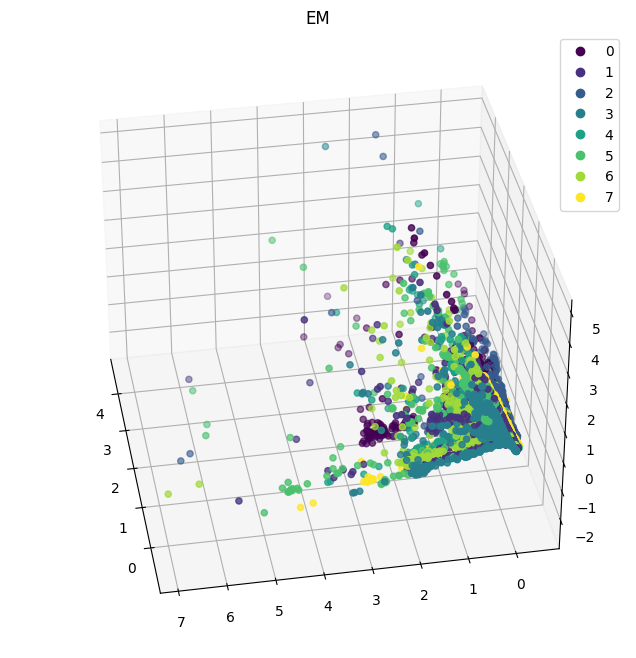

In [24]:
from sklearn.decomposition import PCA

def plot_3d(signal, plot_name, colors, labels, out_path):
    pca = PCA(n_components=3)
    pca_data =pd.DataFrame(pca.fit_transform(signal))
    # visualize in 3d
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    scatter =ax.scatter(pca_data[0],pca_data[1],pca_data[2], c=colors)
    ax.view_init(elev=35, azim=170)
    ax.legend(handles=scatter.legend_elements()[0], loc="best", labels=labels);
    ax.set_title(plot_name);
    plt.savefig(out_path)

# EM scatter
data = em_data
labels = data['labels']
data = data.drop(columns=['labels'])
data = data.dropna(axis='columns')
unique_labels = labels.unique()
labels2colors = {}
classes = []
for i,unique_label in enumerate(unique_labels):
    labels2colors[unique_label] = i
    classes.append(unique_label)
colors = [labels2colors[label] for label in labels]
plot_3d(data,"EM", colors, classes,f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iii)_scatter.pdf')

In [25]:
# Split data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

In [26]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(feature_vector_size,)))
model.add(keras.layers.Dense(1400, activation="relu"))
model.add(keras.layers.Dense(800, activation="relu"))
model.add(keras.layers.Dense(500, activation="relu"))
model.add(keras.layers.Dense(200, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(8, activation="softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [27]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

checkpoint_cb = keras.callbacks.ModelCheckpoint("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iii)_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=30, validation_split=0.1, callbacks=[checkpoint_cb])

Epoch 1/30
2025/2025 [==============================] - 28s 13ms/step - loss: 2.0620 - accuracy: 0.4577 - val_loss: 2.0429 - val_accuracy: 0.6196
Epoch 2/30
2025/2025 [==============================] - 27s 13ms/step - loss: 2.0116 - accuracy: 0.6491 - val_loss: 1.9696 - val_accuracy: 0.6493
Epoch 3/30
2025/2025 [==============================] - 27s 13ms/step - loss: 1.8882 - accuracy: 0.6435 - val_loss: 1.7687 - val_accuracy: 0.5333
Epoch 4/30
2025/2025 [==============================] - 31s 15ms/step - loss: 1.6131 - accuracy: 0.6815 - val_loss: 1.4525 - val_accuracy: 0.8401
Epoch 5/30
2025/2025 [==============================] - 27s 14ms/step - loss: 1.2992 - accuracy: 0.9476 - val_loss: 1.1184 - val_accuracy: 0.9585
Epoch 6/30
2025/2025 [==============================] - 25s 12ms/step - loss: 0.9194 - accuracy: 0.9254 - val_loss: 0.7137 - val_accuracy: 0.9704
Epoch 7/30
2025/2025 [==============================] - 26s 13ms/step - loss: 0.5506 - accuracy: 0.9547 - val_loss: 0.4145 -

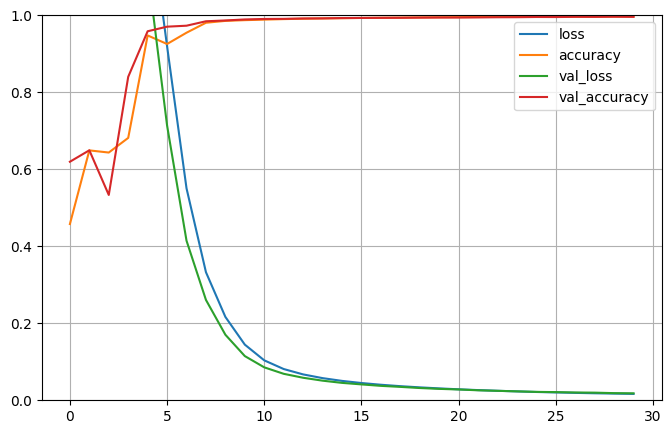

In [28]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [29]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iii)_model.h5")

In [30]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

250/250 [==============================] - 1s 5ms/step - loss: 0.0270 - accuracy: 0.9955
test loss, test acc: [0.027040977030992508, 0.9955000281333923]


In [31]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

250/250 [==============================] - 2s 4ms/step
[0 0 3 ... 6 4 6]
0
[[ 926    0    0    0    0    0    0    1]
 [   0  990    0    0    2    2    5    0]
 [   0    0  975    0    0    0    0    4]
 [   0    0    0  972    0    0    4    0]
 [   0    3    0    0 1074    0    3    0]
 [   0    1    0    0    0 1014    0    1]
 [   0    5    0    0    0    0 1010    0]
 [   0    1    2    0    1    1    0 1003]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       927
           1       0.99      0.99      0.99       999
           2       1.00      1.00      1.00       979
           3       1.00      1.00      1.00       976
           4       1.00      0.99      1.00      1080
           5       1.00      1.00      1.00      1016
           6       0.99      1.00      0.99      1015
           7       0.99      1.00      0.99      1008

    accuracy                           1.00      8000
   macro avg       1.00      1.00     

Test Accuracy:0.9955


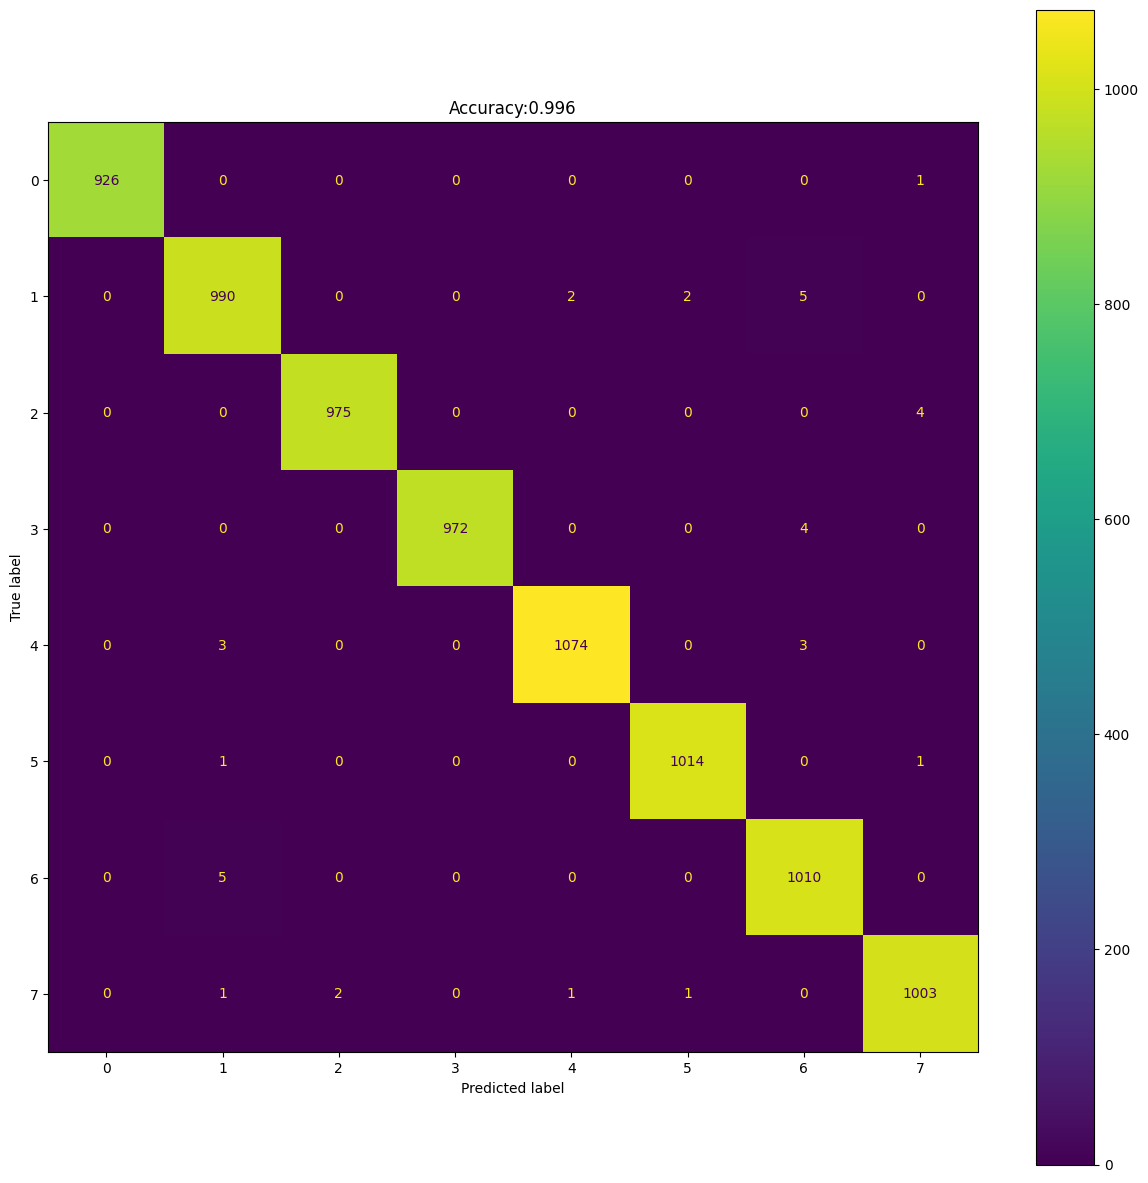

In [32]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,y_test)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/2.4GHz/Device-25/Nordic-device-25-Own_models/iNordic-25(iii)_confusion_matrix.pdf')